<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/OneVSAllProva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to show performances augmenting samples of the imbalanced class with random gaussian noise of zero mean and variance 0.05 as suggested in DOI: 10.1155/2020/3215681

In [1]:
!pip install heartpy
!pip install PyWavelets

In [2]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from scipy.signal import resample, butter, lfilter, iirnotch
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import pywt as pw
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [ ]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [5]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [6]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 609.25it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [7]:
# downsampling signal 


ids_128 = df[df['frequencies'] == 128].index.tolist() 
ids_250 = df[df['frequencies'] == 250].index.tolist() 
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_250[0]]['ecg_lead_1'])


for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

df.head()

100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N']


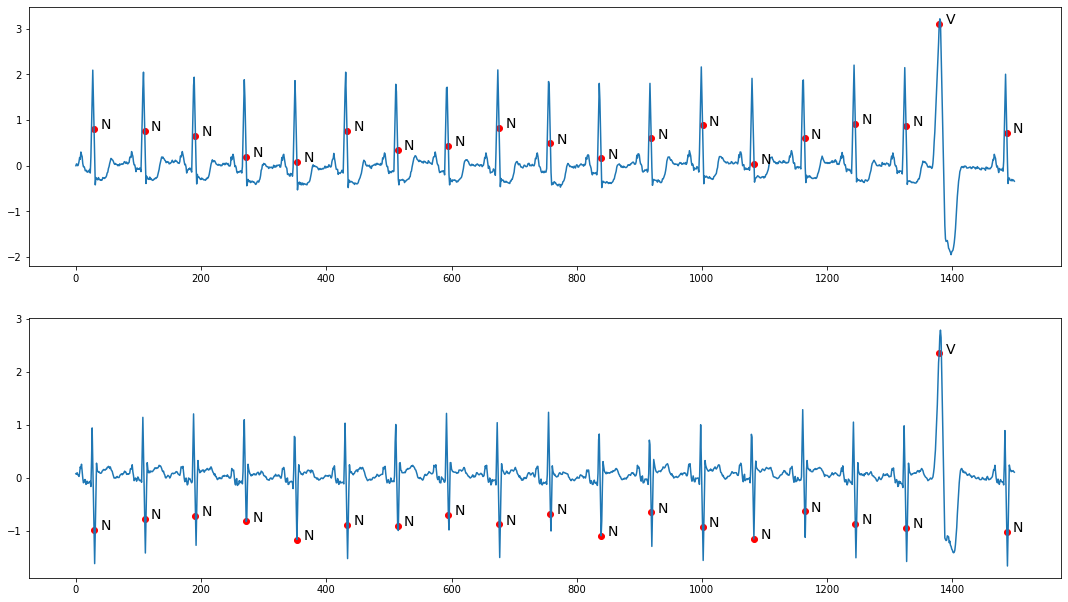

['N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S']


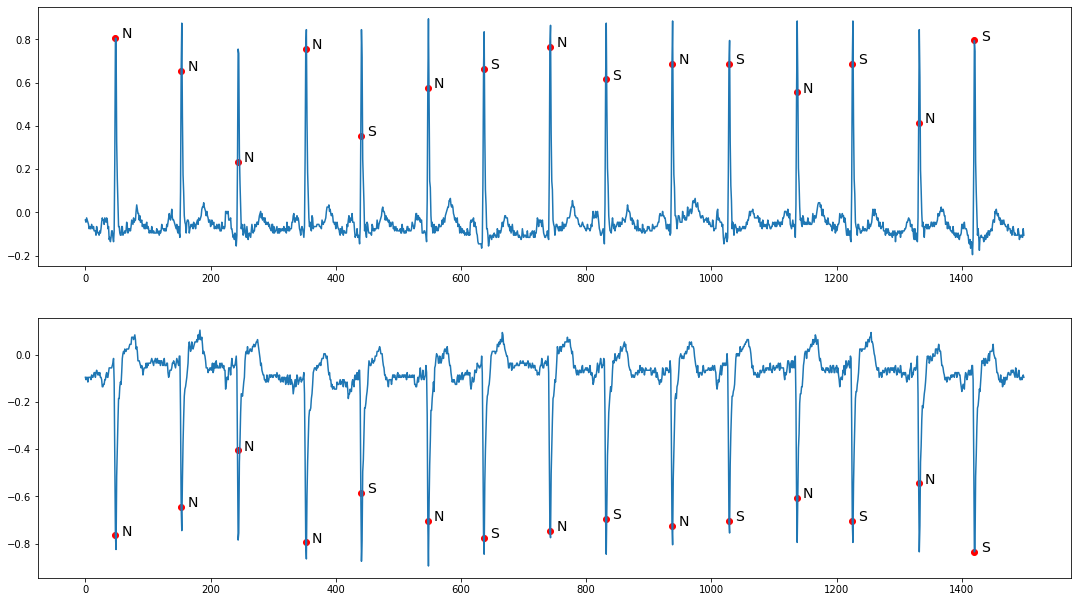

['N', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'N']


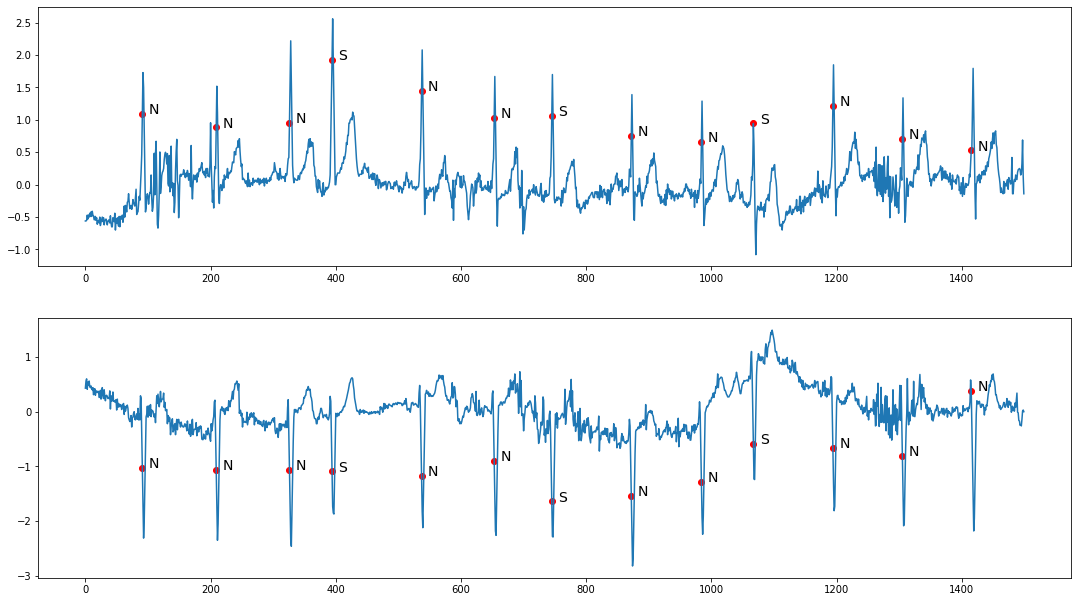

In [8]:
# plot signal 

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()



plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)

100%|██████████| 105/105 [00:04<00:00, 25.42it/s]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N']


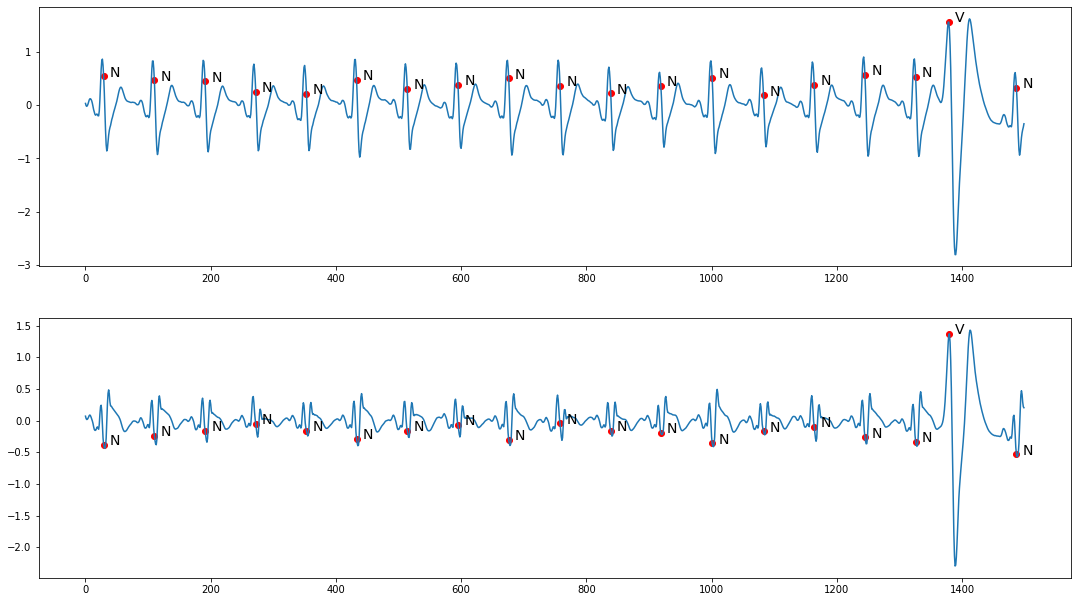

['N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S', 'N', 'S']


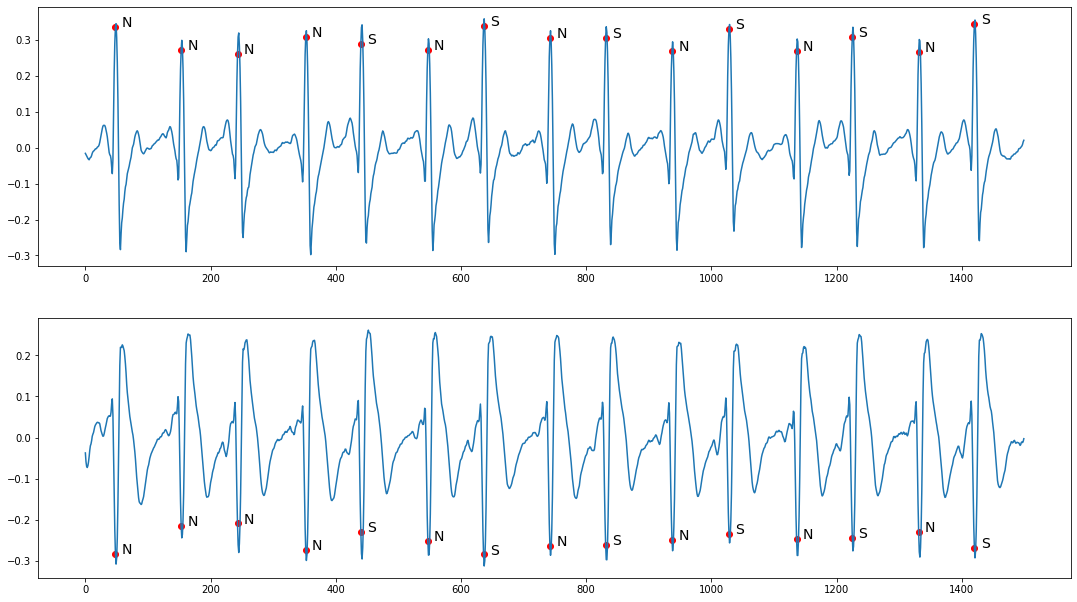

['N', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'N']


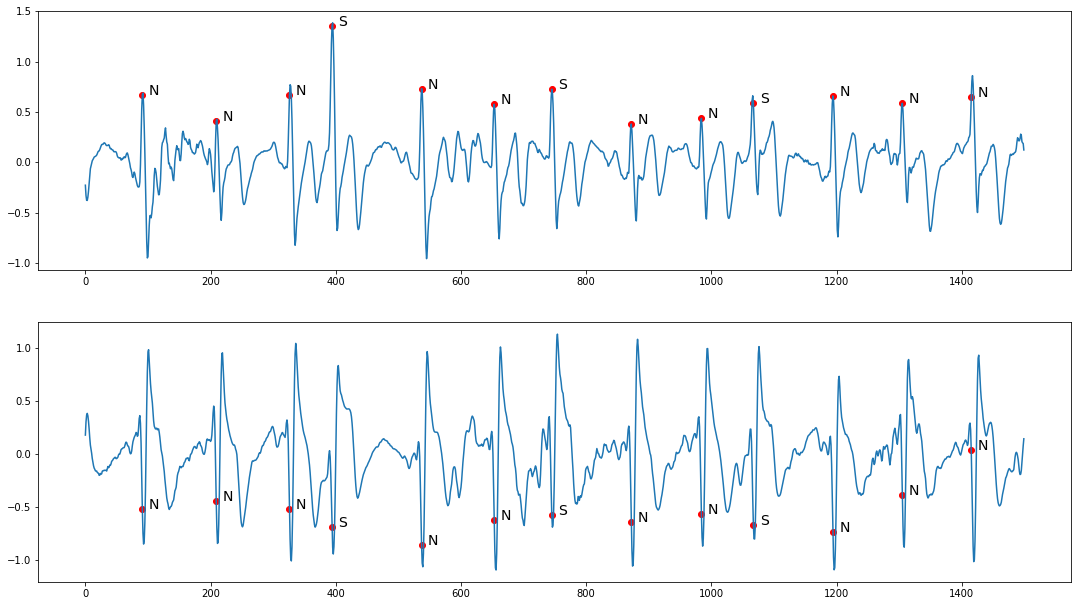

In [9]:
#Preprocessing used in practical lessons
#Preprocessing used in practical lessons

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
def bandpass_filter(data, filter_order=5, lowcut = .8, highcut = 45, signal_freq=128):# Bene V ma non S
#def bandpass_filter(data, filter_order=5, lowcut = .8, highcut = 55, signal_freq=128):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        powerline = 60
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        #b,a = notch_filter(powerline,signal_freq)
        #y = lfilter(b,a,data)
        return y


# center signals and remove baseline 
ids = df['sigId'].index
for id in tqdm(ids):
    row = df.iloc[id]
    
    first_sig = np.array(row['ecg_lead_1'])
    second_sig = np.array(row['ecg_lead_2'])
    
    first_sig = bandpass_filter(first_sig)
    second_sig = bandpass_filter(second_sig)

    #first_sig = hp.enhance_ecg_peaks(first_sig, 128)
    first_sig = hp.smooth_signal(first_sig, 128)
    #first_sig = hp.remove_baseline_wander(first_sig, 128,cutoff=0.01)
    #second_sig = hp.enhance_ecg_peaks(second_sig, 128)
    second_sig = hp.smooth_signal(second_sig, 128)
    #second_sig = hp.remove_baseline_wander(second_sig, 128,cutoff=0.01)
    

    # https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
    # create a normalized Hanning window
    #windowSize = 5
    #window = np.hanning(windowSize)
    #window = window / window.sum()
    #first_sig = np.convolve(window, first_sig, mode='same')
    #second_sig = np.convolve(window, second_sig, mode='same')
    #first_sig = ((first_sig - first_sig.min())/(first_sig.max()-first_sig.min())).tolist()
    #second_sig = ((second_sig - second_sig.min())/(second_sig.max()-second_sig.min())).tolist()

    #first_sig = ((first_sig - first_sig.mean())/(first_sig.std()))#.tolist()
    #second_sig = ((second_sig - second_sig.mean())/(second_sig.std()))#.tolist()
    df.iloc[id]['ecg_lead_1'] = first_sig[:]
    df.iloc[id]['ecg_lead_2'] = second_sig[:]

plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)


In [ ]:
import gc
del training_patches_df
del training_df
del validation_patches_df
del validation_df
gc.collect()

193

In [ ]:
row = df.loc[48]
len(row['peaks'])

1853

In [10]:
# trying https://arxiv.org/pdf/1805.00794.pdf preprocessing and patch extraction

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_v2(df):
  dataset_dict = {}
  ids = df.index.tolist()
  offset = 50
  for id in tqdm(ids):
      row =  df.loc[id]

      peaks = row['peaks']
      first_sig = row['ecg_lead_1']
      second_sig = row['ecg_lead_2']
      labels = row['labels']  
      #1) Splitting the continuous ECG signal to 10s(1280 samples @128Hz) windows and select a 10s window from an ECG signal.
      for i in range(0, min(len(first_sig), len(second_sig)), 1280):
        first_sig_window = first_sig[i:i+1280]
        second_sig_window = second_sig[i:i+1280]
        #2) Normalizing the amplitude values to the range of between zero and one.
        
        #first_sig_std = (2*((first_sig_window - first_sig_window.min())/(first_sig_window.max()-first_sig_window.min()))-1).tolist()
        #second_sig_std = (2*((second_sig_window - second_sig_window.min())/(second_sig_window.max()-second_sig_window.min()))-1).tolist()
        ###
        #first_sig_std = hp.remove_baseline_wander(first_sig_std, 128,cutoff=0.05)
        #second_sig_std = hp.remove_baseline_wander(second_sig_std, 128,cutoff=0.05)
        ###
        #first_sig[i:i+1280] = first_sig_std
        #second_sig[i:i+1280] = second_sig_std          
        first_sig[i:i+1280] = first_sig_window
        second_sig[i:i+1280] = second_sig_window

      #3) Finding the set of all local maximums based on zerocrossings of the first derivative. NOT NEEDED
      #4) Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. NOT NEEDED
      #5) Finding the median of R-R time intervals as the nominal heartbeat period of that window (T).
      T = 0
      rr_list = list()


      if(len(peaks) != len(labels)):
          print("ERROR")

      for i,peak in enumerate(peaks): #compute each R-R time (in samples)
        if i != len(peaks)-1:
          rr = peaks[i+1]-peaks[i]
          rr_list.append(rr)
          
      
      import statistics

      T = statistics.median(rr_list)
      #6) For each R-peak, selecting a signal part with the length equal to 1.2T.
      #patch_length=2*int(1.5*T)
      #max_len = 500
      
      
      ###

      
      max_len = 500
      #6B) Setting last peak RR as T
      rr_list.append(T)

      l = len(peaks)
      #7) Padding each selected part with zeros to make its length equal to a predefined fixed length.
      for i,peak in enumerate(peaks):
          if i == 0:
            k = 0
            h = peaks[i+1]+offset
          elif i ==  l -1:
            k = peaks[i-1]-offset
            h = len(first_sig)
        
          else:
            k = peaks[i-1]-offset
            h = peaks[i+1]+offset

          if k < 0:
            k = 0
          if h > len(first_sig):
            h = len(first_sig)

        
          first_lead = first_sig[k:h] 
          second_lead = second_sig[k:h] 


          index = str(id)+'_'+str(i)
          dataset_dict[index] = {}
          
          first_lead = (255*(first_lead - first_lead.min())/(first_lead.max()-first_lead.min())).tolist()
          second_lead = (255*(second_lead - second_lead.min())/(second_lead.max()-second_lead.min())).tolist()
          first_lead = resample(first_lead, max_len)
          second_lead = resample(second_lead, max_len)
          dataset_dict[index]["first_lead"] = first_lead
          dataset_dict[index]["second_lead"] = second_lead
          dataset_dict[index]["RR_d"] = rr_list[i]
          dataset_dict[index]["stringLabel"] = labels[i]
          dataset_dict[index]["label"] = convert_to_one_hot(labels[i])

  dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
  return dataset_df    

classes = np.array(["N","S","V"])
validation_percentage = 0.25
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)
training_patches_df = create_patch_v2(training_df)
validation_patches_df = create_patch_v2(validation_df)
validation_patches_df



100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


,first_lead,second_lead,RR_d,stringLabel,label
65_0,"[80.41396277892079, 81.5469500715883, 70.58492...","[118.8908361782424, 114.34825016364573, 109.36...",82.0,N,"[1.0, 0.0, 0.0]"
65_1,"[122.20993171706859, 120.22365829175915, 111.5...","[119.44827109026491, 115.20701268115357, 107.7...",86.0,N,"[1.0, 0.0, 0.0]"
65_2,"[122.99056681709537, 126.78006959400166, 122.2...","[90.26528236225595, 88.31286820870204, 94.6682...",91.0,N,"[1.0, 0.0, 0.0]"
65_3,"[183.79553997110796, 189.83894953082415, 168.4...","[113.05271572462459, 112.46827400545475, 114.2...",90.0,N,"[1.0, 0.0, 0.0]"
65_4,"[129.16134699638616, 129.59414318747707, 119.7...","[107.41425294107985, 107.06543350060072, 110.9...",94.0,N,"[1.0, 0.0, 0.0]"
...,...,...,...,...,...
87_2084,"[102.17999234653972, 103.23586352374228, 104.5...","[203.87245101057357, 200.33568744283062, 200.9...",101.0,N,"[1.0, 0.0, 0.0]"
87_2085,"[94.10521393883731, 93.72602509324922, 100.608...","[238.06539099017712, 235.00979153248855, 236.3...",99.0,N,"[1.0, 0.0, 0.0]"
87_2086,"[123.32092118064206, 124.16188673168838, 125.6...","[196.35572256258882, 194.6908464134217, 193.66...",100.0,N,"[1.0, 0.0, 0.0]"
87_2087,"[98.88661905782288, 113.14809826100037, 99.967...","[206.26584920416693, 200.05950095638303, 206.0...",103.0,N,"[1.0, 0.0, 0.0]"


In [9]:
# trying https://arxiv.org/pdf/1805.00794.pdf preprocessing and patch extraction

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_v2(df):
  dataset_dict = {}
  ids = df.index.tolist()
  offset = 0
  for id in tqdm(ids):
      row =  df.loc[id]

      peaks = row['peaks']
      first_sig = row['ecg_lead_1']
      second_sig = row['ecg_lead_2']
      labels = row['labels']  
      #1) Splitting the continuous ECG signal to 10s(1280 samples @128Hz) windows and select a 10s window from an ECG signal.
      for i in range(0, min(len(first_sig), len(second_sig)), 1280):
        first_sig_window = first_sig[i:i+1280]
        second_sig_window = second_sig[i:i+1280]
        #2) Normalizing the amplitude values to the range of between zero and one.
        
        #first_sig_std = (2*((first_sig_window - first_sig_window.min())/(first_sig_window.max()-first_sig_window.min()))-1).tolist()
        #second_sig_std = (2*((second_sig_window - second_sig_window.min())/(second_sig_window.max()-second_sig_window.min()))-1).tolist()
        ###
        #first_sig_std = hp.remove_baseline_wander(first_sig_std, 128,cutoff=0.05)
        #second_sig_std = hp.remove_baseline_wander(second_sig_std, 128,cutoff=0.05)
        ###
        #first_sig[i:i+1280] = first_sig_std
        #second_sig[i:i+1280] = second_sig_std          
        first_sig[i:i+1280] = first_sig_window
        second_sig[i:i+1280] = second_sig_window

      #3) Finding the set of all local maximums based on zerocrossings of the first derivative. NOT NEEDED
      #4) Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. NOT NEEDED
      #5) Finding the median of R-R time intervals as the nominal heartbeat period of that window (T).
      T = 0
      rr_list = list()


      if(len(peaks) != len(labels)):
          print("ERROR")

      for i,peak in enumerate(peaks): #compute each R-R time (in samples)
        if i != len(peaks)-1:
          rr = peaks[i+1]-peaks[i]
          rr_list.append(rr)
          
      
      import statistics

      T = statistics.median(rr_list)
      #6) For each R-peak, selecting a signal part with the length equal to 1.2T.
      patch_length=2*int(1.5*T)
      max_len = 500
      
      ###
      #patch_length = 500
      #max_len = 500
      
      #6B) Setting last peak RR as T
      rr_list.append(T)
      #7) Padding each selected part with zeros to make its length equal to a predefined fixed length.
      for i,peak in enumerate(peaks):
          index = str(id)+'_'+str(i)
          dataset_dict[index] = {}
          first_lead = list()
          second_lead = list()

          #size = list(range(peak-offset,int(max_len+peak)-offset))
          size = list(range(peak+offset,int(peak+max_len)+offset))
          if(len(size) != max_len):
              print("error")
          for s in size:
              if(s >= len(first_sig) or s >= (peak + patch_length/2)  or s < 0):   # padding with 0
                  first_lead.append(0.) 
                  second_lead.append(0.) 
              else:
                  first_lead.append(first_sig[s])
                  second_lead.append(second_sig[s])
          
          first_lead = np.asarray(first_lead).astype(np.float32)
          second_lead = np.asarray(second_lead).astype(np.float32)
          first_lead = (255*(first_lead - first_lead.min())/(first_lead.max()-first_lead.min())).tolist()
          second_lead = (255*(second_lead - second_lead.min())/(second_lead.max()-second_lead.min())).tolist()
          dataset_dict[index]["first_lead"] = first_lead
          dataset_dict[index]["second_lead"] = second_lead
          dataset_dict[index]["RR_d"] = rr_list[i]
          dataset_dict[index]["stringLabel"] = labels[i]
          dataset_dict[index]["label"] = convert_to_one_hot(labels[i])

  dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
  return dataset_df    

classes = np.array(["N","S","V"])
validation_percentage = 0.2
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)
training_patches_df = create_patch_v2(training_df)
validation_patches_df = create_patch_v2(validation_df)
validation_patches_df



  4%|▎         | 3/84 [00:12<05:42,  4.23s/it]


KeyboardInterrupt: ignored

In [10]:
#fixed patch

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_v2(df):
  dataset_dict = {}
  ids = df.index.tolist()
  offset = 0
  for id in tqdm(ids):
      row =  df.loc[id]

      peaks = row['peaks']
      first_sig = row['ecg_lead_1']
      second_sig = row['ecg_lead_2']
      labels = row['labels']  
      #1) Splitting the continuous ECG signal to 10s(1280 samples @128Hz) windows and select a 10s window from an ECG signal.
      for i in range(0, min(len(first_sig), len(second_sig)), 1280):
        first_sig_window = first_sig[i:i+1280]
        second_sig_window = second_sig[i:i+1280]
        #2) Normalizing the amplitude values to the range of between zero and one.
        
        #first_sig_std = (2*((first_sig_window - first_sig_window.min())/(first_sig_window.max()-first_sig_window.min()))-1).tolist()
        #second_sig_std = (2*((second_sig_window - second_sig_window.min())/(second_sig_window.max()-second_sig_window.min()))-1).tolist()
        ###
        #first_sig_std = hp.remove_baseline_wander(first_sig_std, 128,cutoff=0.05)
        #second_sig_std = hp.remove_baseline_wander(second_sig_std, 128,cutoff=0.05)
        ###
        #first_sig[i:i+1280] = first_sig_std
        #second_sig[i:i+1280] = second_sig_std          
        first_sig[i:i+1280] = first_sig_window
        second_sig[i:i+1280] = second_sig_window

      #3) Finding the set of all local maximums based on zerocrossings of the first derivative. NOT NEEDED
      #4) Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. NOT NEEDED
      #5) Finding the median of R-R time intervals as the nominal heartbeat period of that window (T).
      T = 0
      rr_list = list()


      if(len(peaks) != len(labels)):
          print("ERROR")

      for i,peak in enumerate(peaks): #compute each R-R time (in samples)
        if i != len(peaks)-1:
          rr = peaks[i+1]-peaks[i]
          rr_list.append(rr)
          
      
      import statistics

      T = statistics.median(rr_list)
      #6) For each R-peak, selecting a signal part with the length equal to 1.2T.
      patch_length=2*int(1.5*T)
      max_len = 500
      
      ###
      #patch_length = 500
      #max_len = 500
      
      #6B) Setting last peak RR as T
      rr_list.append(T)
      #7) Padding each selected part with zeros to make its length equal to a predefined fixed length.
      for i,peak in enumerate(peaks):
          index = str(id)+'_'+str(i)
          dataset_dict[index] = {}
          first_lead = list()
          second_lead = list()

          #size = list(range(peak-offset,int(max_len+peak)-offset))
          size = list(range(int(peak-max_len/2)+offset,int(peak+max_len/2)+offset))
          if(len(size) != max_len):
              print("error")
          for s in size:
              if(s >= len(first_sig) or s >= (peak + patch_length/2) or s <= (peak -patch_length/2) or s < 0):   # padding with 0
                  first_lead.append(0.) 
                  second_lead.append(0.) 
              else:
                  first_lead.append(first_sig[s])
                  second_lead.append(second_sig[s])
          
          first_lead = np.asarray(first_lead).astype(np.float32)
          second_lead = np.asarray(second_lead).astype(np.float32)
          first_lead = (255*(first_lead - first_lead.min())/(first_lead.max()-first_lead.min())).tolist()
          second_lead = (255*(second_lead - second_lead.min())/(second_lead.max()-second_lead.min())).tolist()
          dataset_dict[index]["first_lead"] = first_lead
          dataset_dict[index]["second_lead"] = second_lead
          dataset_dict[index]["RR_d"] = rr_list[i]
          dataset_dict[index]["stringLabel"] = labels[i]
          dataset_dict[index]["label"] = convert_to_one_hot(labels[i])

  dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
  return dataset_df    

classes = np.array(["N","S","V"])
validation_percentage = 0.2
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)
training_patches_df = create_patch_v2(training_df)
validation_patches_df = create_patch_v2(validation_df)
validation_patches_df



 57%|█████▋    | 48/84 [05:02<03:47,  6.31s/it]


KeyboardInterrupt: ignored

In [ ]:
validation_patches_df[(validation_patches_df['stringLabel']=='S')]

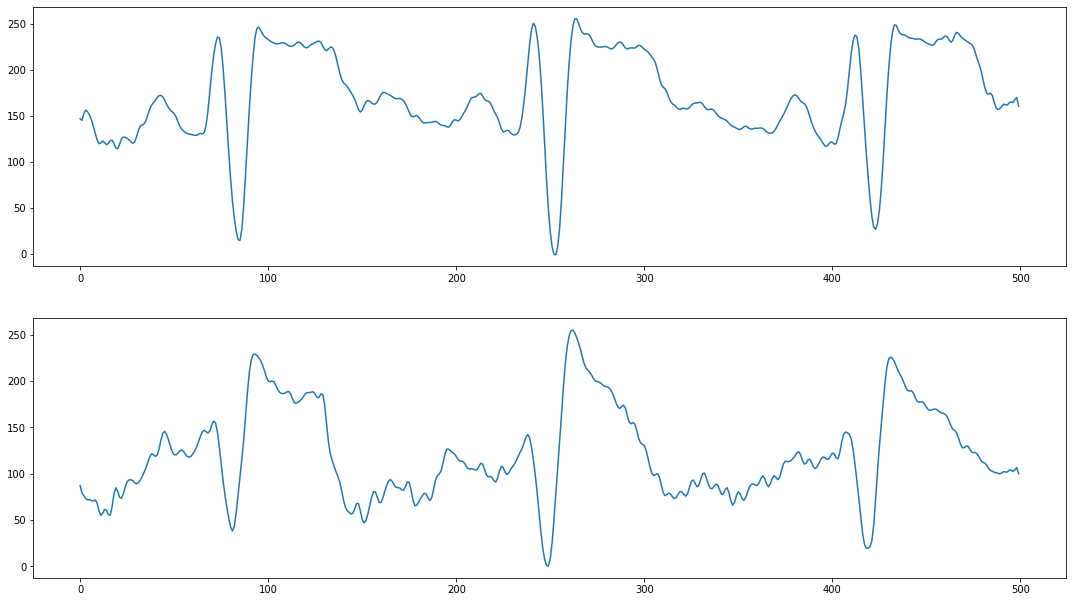

In [10]:
    
    signal = validation_patches_df.loc["35_7"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

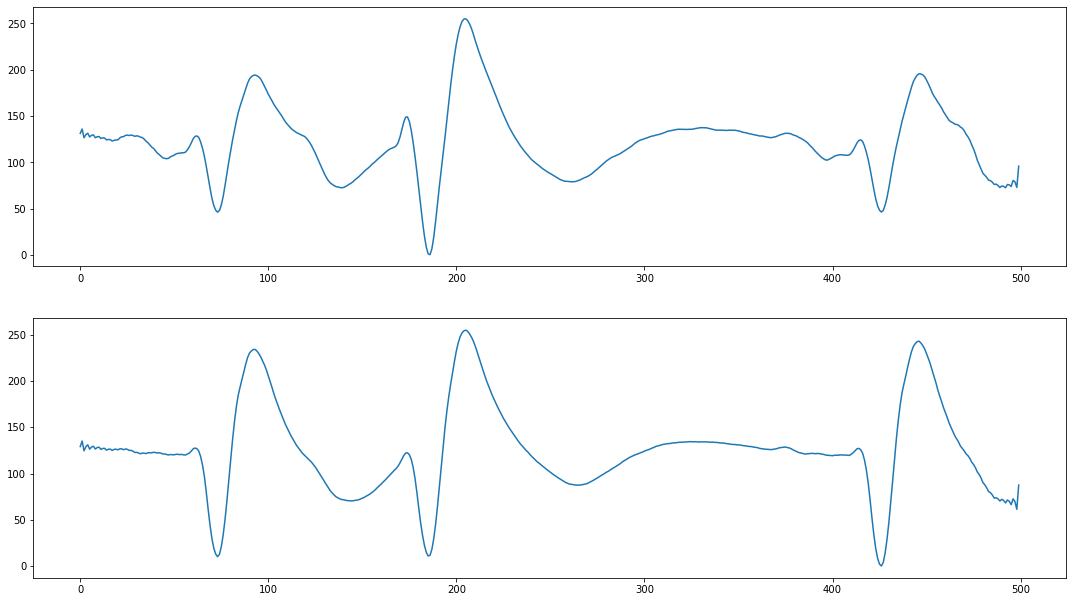

In [ ]:
    signal = validation_patches_df.loc["48_1229"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

In [ ]:
validation_patches_df[(validation_patches_df['stringLabel']=='V')]

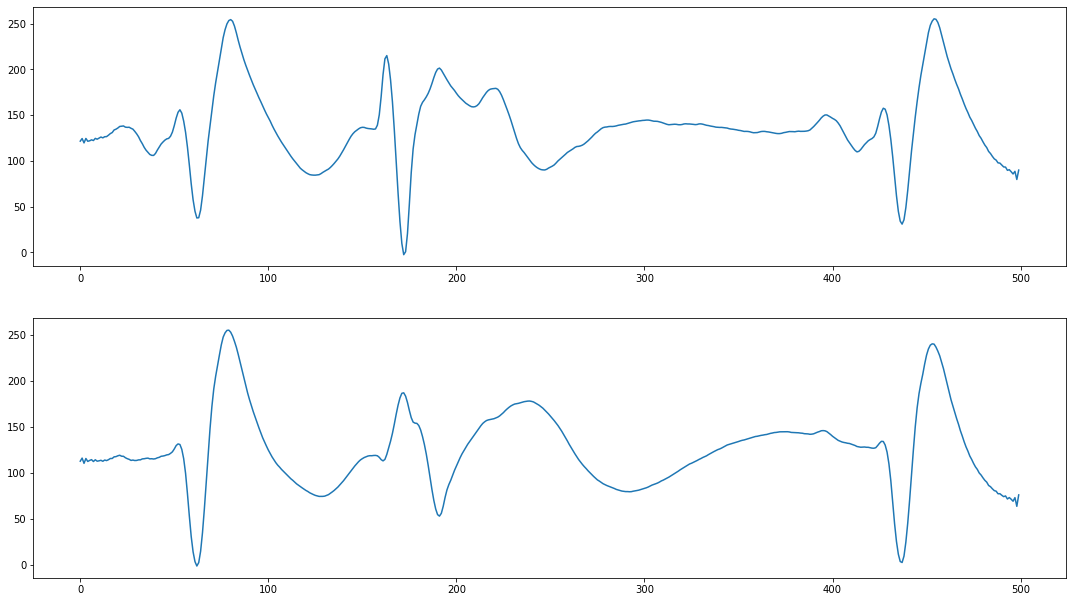

In [ ]:
    signal = validation_patches_df.loc["48_1599"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

N: 169801
V: 14839


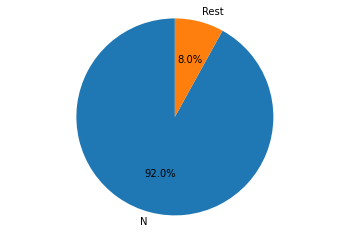

N: 57131
V: 2565


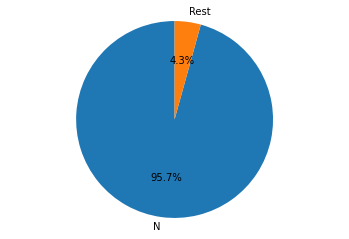

In [11]:
# count classes for training

ids_n = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist() 
ids_rest = training_patches_df.index[training_patches_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

classes = ["N","Rest"]
counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

# count classes for validation

ids_n = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist() 
ids_rest = validation_patches_df.index[validation_patches_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [12]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=np.squeeze(y_true), predictions=np.rint(np.squeeze(y_pred))).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [13]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['stringLabel']!='N')

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    

    return x,y

In [14]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)
y_train

100%|██████████| 59696/59696 [00:17<00:00, 3359.32it/s]


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [21]:
from sklearn.utils.class_weight import compute_class_weight
timesteps = 500 #patch size
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_NvsRest = keras.models.Model(inputs=input, outputs=output)

model_NvsRest.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 64
learning_rate = 1e-5
model_NvsRest.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = y_train, 
                                            y = y_train
                                        )
d_class_weights = dict(enumerate(class_weights))

history = model_NvsRest.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 50,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history


y_pred = model_NvsRest.predict(x_valid)

plot_confusion_matrix(y_valid, y_pred)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500, 2)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 476, 32)           1632      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 238, 32)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 238, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 227, 64)           24640     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 113, 64)          0         
 g1D)                                                      

KeyboardInterrupt: ignored

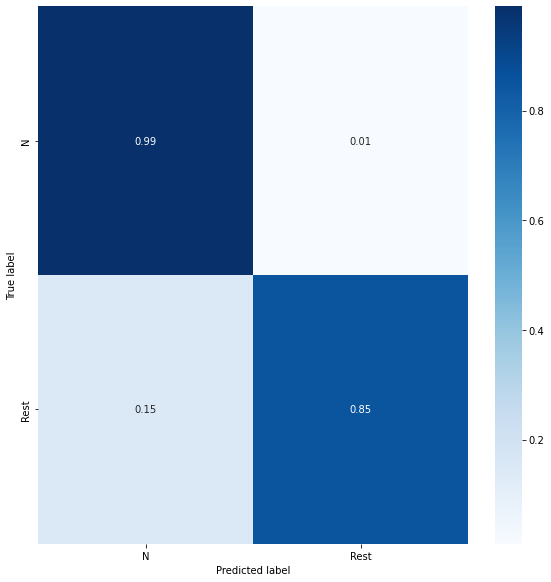

In [23]:
import seaborn as sns
y_pred = model_NvsRest.predict(x_valid)

plot_confusion_matrix(y_valid, y_pred)

In [ ]:

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'ResNetV0x3Peaks_history.csv'
with open(os.path.join(cwd,hist_csv_file), mode='w') as f:
    hist_df.to_csv(f)

nn.save_weights(os.path.join(cwd,'ResNetV0x3Peaks_weights.h5'))
nn.save(os.path.join(cwd,'ResNetV0x3Peaks'))

INFO:tensorflow:Assets written to: G:\Il mio Drive\Colab2022/AppliedAI/FinalAssignment\ResNetV0\assets


C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\user\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
